In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
import control as ctl
from time import time, sleep

# ANÁLISE DOS DADOS
- Extraindo os dados da tabela e verificando os outliers

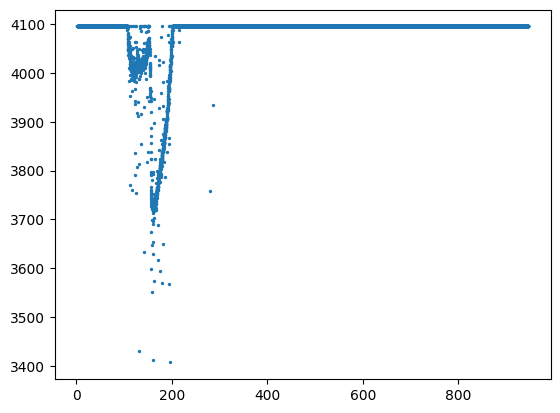

In [43]:
df = pd.read_csv('DataBase.csv')
xData = df['time'].to_numpy()
yData = df['analog'].to_numpy()

plt.scatter(xData, yData, s=2)

- Filtrando pelos dados em que ocorre o decaimento, onde o filtro precisa atuar com sua maior precisão

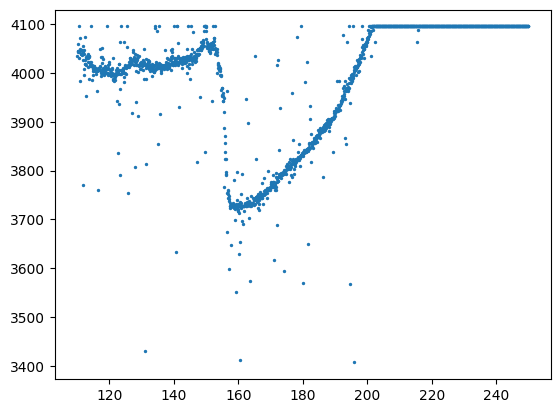

In [44]:
df = pd.read_csv('DataBase.csv')
df = df.loc[(df['time'] > 110) & (df['time'] < 250)]

xData = df['time'].to_numpy()
yData = df['analog'].to_numpy()

plt.scatter(xData, yData, s=2)

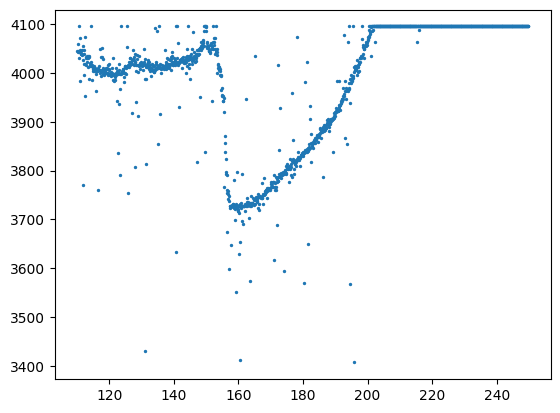

In [45]:
def normalizeData(time, response, T=0.01):
    timeIntervals = np.arange(np.min(time), np.max(time), T)
    xData = []
    yData = []

    for i in range(len(timeIntervals) - 1):
        position      = timeIntervals[i]
        next_position = timeIntervals[i + 1]

        target = response[(time > position) & (time <= next_position)]
        
        if len(target) == 0:
            continue
        
        t = (next_position + position)/2
        y = np.min(target)

        xData.append(t)
        yData.append(y)

    return xData, yData

xData, yData = normalizeData(xData, yData, T=0.1)
plt.scatter(xData, yData, s=2)

# DOMÍNIO DA FREQUÊNCIA
- Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

(0.0, 10000.0)

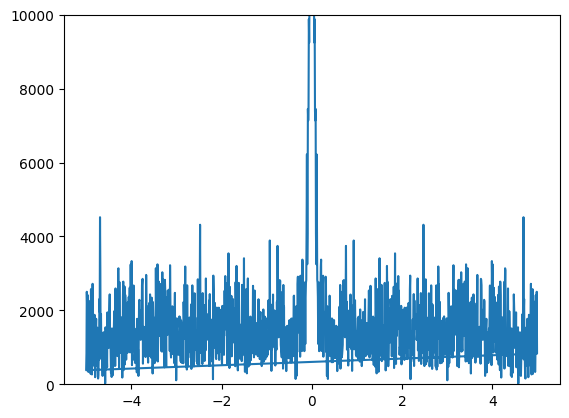

In [46]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), xData[1] - xData[0])

plt.plot(frequency, np.abs(magnitude))
plt.ylim(0, 10000)

### FILTRO PASSA BAIXA
- O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueada

In [47]:
f_c = 0.1

(0.0, 10000.0)

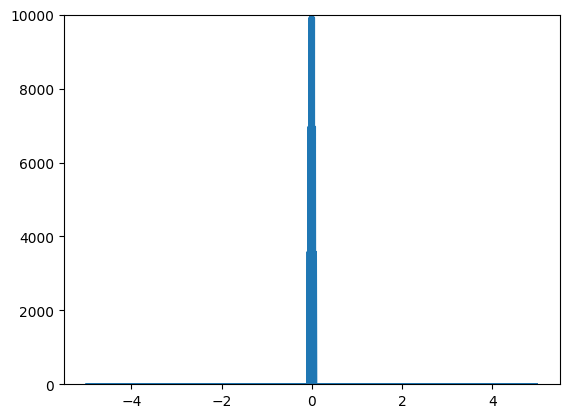

In [48]:
def passaBaixa(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray


magnitude = passaBaixa(frequency, magnitude, f_c)
plt.plot(frequency, magnitude.real)
plt.ylim(0, 10000)

- Voltando para o domínio do tempo

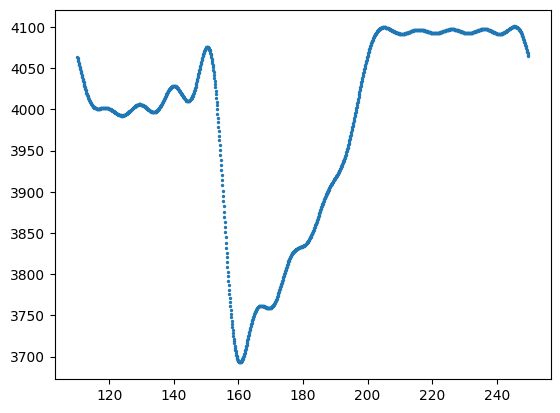

In [49]:
yData = np.fft.ifft(magnitude).real
plt.scatter(xData, yData, s=2)

## CONFERINDO RESULTADOS

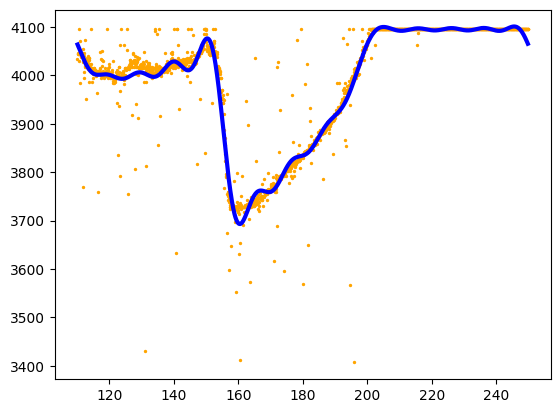

In [50]:
plt.scatter(df['time'], df['analog'], s=2, color='orange')
plt.plot(xData, yData, color='blue', linewidth=3)